In [Notebook 3](https://github.com/FabCec/planned_replacements/blob/master/3.%20Exploratory%20data%20analysis%20and%20inferential%20statistic.ipynb) we explored the dataset and obtained insights on the fraction of failures that could be prevented by means of predictive replacement. Most of the HDDs which fail do not show substantial change in their SMART metrics and thus won't be detected. Nevertheless, we aim to detect those which do. In this notebook we aim to use machine learning techniques in order to determine whether an HDD is close to failure (and should therefore be turned off), or not. By means of these techniques we aim to determine a good predictive replacement policy to run together with the preventive replacement policy already in operation.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from IPython.display import display

In [2]:
# Hide warnings to facilitate the reading

import warnings
warnings.filterwarnings('ignore')

# A. Revenue model

**Assume that each HDD working on a certain day give a profit of $1$ unit and that the failure of an HDD yields a cost of $C$ units** (where $C \gg 1$). Hence, the revenue on day $t$ is given by 

$$
R_t = A_t - C F_t,
$$

where $A_t$ is the number of HDDs active on day $t$ and $F_t$ is the number of HDDs which failed that same day. **We aim to maximize the total revenue** in a period of interest $T$, i.e., 

$$
R = \sum_{t \in T} R_t. 
$$

Note that when an HDD is labeled as close to failure by our classification algorithm it will be turned off for good, thus preventing it to produce revenue on the following days. Hence, a trade-off has to be found between turning off HDDs too early or missing to turning them off and incur the failure cost. 


In [Notebook 3](https://github.com/FabCec/planned_replacements/blob/master/3.%20Exploratory%20data%20analysis%20and%20inferential%20statistic.ipynb) we identified which metrics could be useful in predicting failures. 

For model Hitachi HDS722020ALA330, we observed that SMART metrics 1, 5, 196 are the only ones having an evolution correlated with the time to failure of an HDDs. We will thus use only these in this notebook. 

We load the dataframes **df_serialnumber** and **df** defined in [Notebook 3](https://github.com/FabCec/planned_replacements/blob/master/3.%20Exploratory%20data%20analysis%20and%20inferential%20statistic.ipynb). 

In [3]:
### Specify which model you want to analyze and which metrics you consider useful

ModelName = 'Hitachi HDS722020ALA330' 
useful_metrics = ['1', '5', '196']

In [4]:
# Load the dataframes saved in Notebook 3

smart_metrics = ['smart_' + x + '_normalized' for x in useful_metrics]
col_names = ['serial_number', 'date', 'failure', 'state', 'D_to_last'] + smart_metrics

folder_name_model = ModelName.replace(' ', '_')
folder_name = 'Data/' + folder_name_model

# Load the main dataframe : df
df = pd.read_csv(folder_name + '/DataFrame.csv', parse_dates=['date'], usecols = col_names)

# Load the serial_number dataframe : df_serialnumber
df_serialnumber = pd.read_csv(folder_name + '/serialnumber.csv', parse_dates = [1,2,3])
df_serialnumber.rename(columns={'Unnamed: 0':'serial_number'}, inplace=True)
df_serialnumber = df_serialnumber.set_index('serial_number')

df.head()

,serial_number,date,failure,smart_1_normalized,smart_5_normalized,smart_196_normalized,state,D_to_last
0,JK1100B8G3B7AT,2015-01-01,0,100.0,100.0,100.0,healthy,-602
1,JK1100B8G3B7AT,2015-01-02,0,100.0,100.0,100.0,healthy,-601
2,JK1100B8G3B7AT,2015-01-03,0,100.0,100.0,100.0,healthy,-600
3,JK1100B8G3B7AT,2015-01-04,0,100.0,100.0,100.0,healthy,-599
4,JK1100B8G3B7AT,2015-01-05,0,100.0,100.0,100.0,healthy,-598


## A.1. Training, testing, and validating data 

Before starting any learning procedure, we have to split the data in training and test data. The policies we will derive later will be based on the training data and evaluated on the testing data.

We apply the splitting procedure on the dataframe df_serialnumber, **we maintain 3/4 of the HDDs for training and save the rest for testing**. We slice over the state of the HDD, i.e., we have approximately the same fraction of failing HDDs in the training and in the testing data.

Then, we further split the training HDDs in 3 folds so as to perform a **3-fold cross validation** as we train our machine learning procedures and tune the algorithm's parameters.

For the model Hitachi HDS722020ALA330 we have: 

|                | Training data     | Testing data |
| :------------- |--------------:| --------:|
| Observations   | 1954262       | 653358   |
| Unique HDDs    | 3512          |   1171   |
| Failing Models | 113           |   38     |

The three folds are approximately of the same dimension: 651263, 651789, and 651210 observtaions.

In [5]:
# Split training and testing HDDs

from sklearn.model_selection import train_test_split

# hdds_X contains a list of unique HDDs (unique serial numbers)
# hdds_y contains a list of 0/1, 1 if the HDD will fail
hdds_X = df_serialnumber.index.values
hdds_y = (df_serialnumber['state'] == 'fail').values

# Split HDDs in training and testing HDDs 
hdds_X_train, hdds_X_test, hdds_y_train, hdds_y_test = train_test_split(hdds_X, hdds_y, random_state = 1, stratify = hdds_y)

# Create a mask for the observations of df based on the train/test HDDs split : training_data_mask & test_data_mask
training_models = set(hdds_X_train)       # Set of training HDDs
training_data_mask = [x in training_models for x in df['serial_number']]
test_data_mask = [not x for x in training_data_mask]


In [6]:
## Split the training HDDs in order to perform an NFolds(=3) cross-validation

from sklearn.cross_validation import KFold

NFolds = 3
kf = KFold(len(hdds_X_train), n_folds = NFolds)    
hdds_X_train_list = hdds_X_train.tolist()          # Create list of training HDDs 

# Select only the training observations and the associated serial numbers
df_train_sn = df.loc[training_data_mask, 'serial_number']

# Create a mask for the training observations based on the NFold cross validation split : training_fold_data_mask & validate_fold_data_mask
## training_fold_data_mask[i,j] = 1 if the i-th observation is in the training set for the j-th cv step
## validate_fold_data_mask[i,j] = 1 if the i-th observation is in the validation set for the j-th cv step
training_fold_data_mask = np.zeros((np.sum(training_data_mask), NFolds))
validate_fold_data_mask = np.zeros((np.sum(training_data_mask), NFolds))

for ind, x in enumerate(df_train_sn) :
    ind_x = hdds_X_train_list.index(x)
    for ind_f, train_test_index in enumerate(kf):
        test_index = train_test_index[1]
        if (ind_x >= test_index[0]) & (ind_x <= test_index[-1]) :
            validate_fold_data_mask[ind, ind_f] = 1
        else : 
            training_fold_data_mask[ind, ind_f] = 1      
        

/home/fabio/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## A.2. Evaluation metric

The policies deduced will be compared with respect to the total revenue $R$. We will use as a benchmark the preventive replacement policy which is currently in use. 

The following functions are used to compute $R$. 

- *revenue_per_day* computes $R_t$ for a specific day. It takes in input (1) C, The cost per failure, (2) turned_off, the set of HDDs that the policy in use prescribed to turn off before day $t$, (3) hdds, the list of HDDs observed that day (those active in the original dataset), (4) failures, The list of 0/1 capturing whether the observed HDDs fail on day $t$.

- *compute_revenue_preventive* computes $R$ in case we use only **preventive replacement policy** with C cost per failure. The dataframe df needs to have the columns 'failure', 'date', and 'serial_number'.

- *compute_revenue_predictive* computes $R$ in case we use also **predictive replacement policy** with C cost per failure. The dataframe df needs to have the columns 'failure', 'date', 'serial_number', and 'predictions'. It also prints the actions taken and the change in revenue they cause.

A couple of observations:

1) **Order of the actions**: At any given day, if an HDD is active we gain $1$. Then, we observe whether it failed and eventually lose $C$. If it does not fail, we run the predictive replacement policy and decide whether to turn it off before the day after. In particular, if we predict an HDD to be close to failure on the day it fails, we are one day too late and missed the opportunity to turn it off, i.e., we still incur in the cost of the failure.

2) **Alternative formula for preventive replacement revenue**: In case of only preventive replacement, the total revenue is influenced only by the value of $C$ and the number of failing HDDs. In fact, the total revenue is given by $R = \text{max_revenue} - C F$ where max_revenue is the revenue obtained in a scenario with $C = 0$ and $F$ are the number of failures in the period considered.


In [7]:
def revenue_per_day(C, turned_off, hdds, failures) :
    '''For a given day, add 1 for every hdd in hdds which do not fail on that day and was not already turned off. Remove 50 if the hdd is on and failed on that day.'''
    # Initialize revenue at 0
    revenue = 0   
    for ind in range(len(hdds)) : 
        off = hdds[ind] in turned_off
        on = 1 - off
        # For each active HDDs either increase the revenue by 1 (if not failing) or decrease it by C (if failing). 
        revenue = revenue + on - on*C*failures[ind]
    return revenue    
   
# List of dates we consider, everyday in 2015, 2016, and 2017    
dates = df.date.unique()    
    
def compute_revenue_preventive(dates, C, df) :
    '''Compute total revenue in the time period determined by dates, given the cost per-failure C and the dataframe df.'''
    # Revenue will be a list of values, where revenue[s] is equal to the revenue on the s-th day
    revenue = []
    # With preventive policy only, we will never turn off any HDD prior to their failure, i.e., turned_off will always be an empty set 
    turned_off = set()
    for ind, day in enumerate(dates) :
        df_day = df[df['date']==day]
        revenue.append(revenue_per_day(C, turned_off, df_day['serial_number'].values, df_day['failure'].values))
    return np.cumsum(revenue)

def compute_revenue_predictive(dates, C, df) :
    '''Compute total revenue in the time period determined by dates, given the cost per-failure C and the dataframe df.
    The dataframe df must contain a column with the predictions, i.e., the HDDs to turn off'''
    revenue = []
    turned_off = set()

    for ind, day in enumerate(dates) :
        df_day = df[df['date']==day]
        revenue.append(revenue_per_day(C, turned_off, df_day['serial_number'].values, df_day['failure'].values))
        # to_turn_off is a list of HDDs that the predictive replacement policy prescribe to turn off on that day
        to_turn_off = df_day.loc[df_day['predictions'] == 1, 'serial_number'].values
        if len(to_turn_off) > 0 :
            for sn in to_turn_off :
                if sn not in turned_off :
                    # If an HDD in to_turn_off has not been turned off yet, we turn it off and print the outcome of the action taken
                    state_sn = df_serialnumber.loc[sn,'state']
                    last_sn = df_serialnumber.loc[sn,'date_last']
                    diff_days = (last_sn-day).days
                    day_dt = day.astype('M8[D]').astype('O')
                    revenue_diff = (state_sn == 'healthy')*(-diff_days) + (state_sn == 'fail')*(diff_days >0)*(-diff_days + C)
                    print('HDD {} is {} and present till {}-{}-{}. We turn it off on {}-{}-{}: change in revenue of {}'.format(sn, state_sn, last_sn.day, last_sn.month, last_sn.year, day_dt.day, day_dt.month, day_dt.year, revenue_diff) )
            turned_off.update(to_turn_off)     
            
    return np.cumsum(revenue)   

    
def compute_revenue_predictive(dates, C, df) :
    '''Compute total revenue in the time period determined by dates, given the cost per-failure C and the dataframe df.
    The dataframe df must contain a column with the predictions, i.e., the HDDs to turn off'''
    revenue = []
    turned_off = set()
    df_actions = pd.DataFrame(columns = ['date_action', 'HDD', 'state_HDD', 'last_presence', 'change_in_revenue'])

    for ind, day in enumerate(dates) :
        df_day = df[df['date']==day]
        revenue.append(revenue_per_day(C, turned_off, df_day['serial_number'].values, df_day['failure'].values))
        # to_turn_off is a list of HDDs that the predictive replacement policy prescribe to turn off on that day
        to_turn_off = df_day.loc[df_day['predictions'] == 1, 'serial_number'].values
        if len(to_turn_off) > 0 :
            for sn in to_turn_off :
                if sn not in turned_off :
                    # If an HDD in to_turn_off has not been turned off yet, we turn it off and print the outcome of the action taken
                    dict_new_action = {
                        'date_action': day,
                        'HDD': sn,
                        'state_HDD': df_serialnumber.loc[sn,'state'],
                        'last_presence': df_serialnumber.loc[sn,'date_last']
                    } 
                    diff_days = (dict_new_action['last_presence']-day).days
                    dict_new_action['change_in_revenue'] = (dict_new_action['state_HDD'] == 'healthy')*(-diff_days) + (dict_new_action['state_HDD'] == 'fail')*(diff_days >0)*(-diff_days + C)
                    #df_new_action = pd.DataFrame.from_dict(dict_new_action)
                    #print(df_new_action)
                    df_actions = df_actions.append(dict_new_action, ignore_index = True)
            turned_off.update(to_turn_off)     
            
    return np.cumsum(revenue), df_actions                      

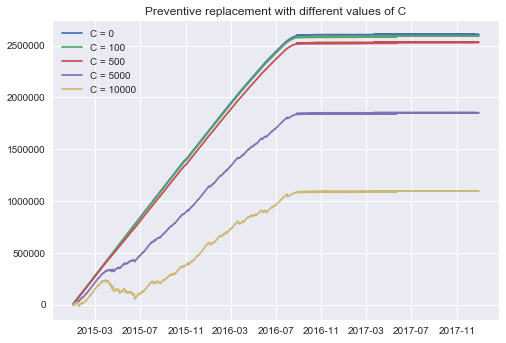

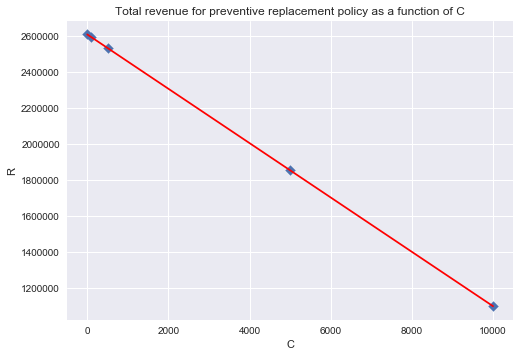

In [8]:
# Compute the total revenue for the case with only preventive replacement and different costs C in Cs

Cs = [0, 100, 500, 5000, 10000]
total_revenue_C = []

for C in Cs :
    cum_revenue = compute_revenue_preventive(dates, C, df)
    total_revenue_C.append(cum_revenue[-1])
    plt.plot(dates, cum_revenue, label = 'C = {}'.format(C))
    
plt.title('Preventive replacement with different values of C')
plt.legend()
plt.savefig(folder_name + '/prev_repl_by_C.jpg')
plt.show()        

max_revenue = total_revenue_C[0]

# Compute the total revenue by means of the function above using the alternative formula 

Failures = np.sum(hdds_y)

C_vec = np.array([0,max(Cs)])
preventive_revenue = max_revenue - C_vec*Failures

# Note the linear dependence on C
plt.scatter(x = Cs, y = total_revenue_C, marker = 'D')      
plt.plot(C_vec, preventive_revenue, 'r')
plt.title('Total revenue for preventive replacement policy as a function of C')
plt.xlabel('C')
plt.ylabel('R')
plt.savefig(folder_name + '/prev_repl_by_C_2.jpg')
plt.show()



#### Is this HDD approaching failure?

Before using supervised machine learning techniques we need to label the observations, i.e., we have to establish whether the observed HDD is approaching failure (label 1) or not (label 0). In particular, we do not want to label with 1 ad thus turn off an HDD which is not close to failure because we would miss on the revenue it would produce in between that day and its last appearance.

To deal with this, **we set a time window $W$ and we label with a $1$ every observation relative to an HDD which will fail in less than $W$ days**. The choice of $W$ should depend on $C$, i.e., a larger the cost for failure should allow a larger window. 

In the exploratory data analysis performed in [Notebook 3](https://github.com/FabCec/planned_replacements/blob/master/3.%20Exploratory%20data%20analysis%20and%20inferential%20statistic.ipynb) we observed that there are no evidence of future failure more than 14 days before it, we thus select $W(C) = \min(C-1, 15)$.

As an example, note that for $C = 0, 1$ there is no advantage in turning off an HDD, and that is reflected by our labeling procedure (none of the observations are labeled with a 1), and the predictive replacement policy will not prescribe any additional action. On the other hand, as $C$ grows large, the window is set to remain at $15$. 

We will be mostly interested in large values of $C$, thus in the following analysis we will set $W = 15$ and label the observations accordingly



In [9]:
# Define the window for a case with large C. Note that the threshold might be model dependent, for model Hitachi HDS722020ALA330 we set it at 15.
W = 15

# Include a label column in the dataset. The entry is 1 if the HDD observed is going to fail in less than W days. 
df['label'] = (df['state'] == 'fail') & (df['D_to_last'] > -W).astype(int)

#### Score of an algorithm

We need to determine a metric that could be used to synthetize the performance of a classifier on the validating data and used to judge the generalization power of the algorithm. 

Given a certain algorithm, it can be used to classify whether a set of observations is relative to HDDs close to failure or not, and we can compare the predictions with the real labels of such observations. The **confusion matrix** applied to these two vectors of labels give us four values:

|                | Predicted $0$       | Predicted $1$             |
| :------------- |--------------------:| -------------------------:|
| **Actual** $0$     | True Negative (tn)  | False Positive (fp)   |
| **Actual** $1$     | False Negative (fn) | True Positive (tp)    |

We would like to find an algorithm which would correctly identify as many HDDs close to failure as possible (high tp), while turning off as low healthy HDDs as possible (low fp). The tradeoff between tp and fp has to be governed by $C$.
We thus the following metric

$$ M = (C-1) * tp - \mathbb{E}\big[df[\text{D_to_last}]\big] * fp. $$

The metric $M$ is given by the expected gain due to correct termination of HDDs minus the expected loss suffered by terminating healthy HDDs (number of healthy HDDs terminated times the average life of an HDD) we would have by using the algorithm. 

A couple of observations on the metric $M$:

1) Observe that the number of tp (true positive) and fp (false positive) is not relative to the unique HDDs identified, multiple tp and fp can be associated to the same HDD. In particular, imagine the same HDD is classified as close to failure for many days in a row, that event would inficiate the meaning of the metric $M$. Nevertheless, since such a sequence of identification could happen both for healthy and failing HDDs, in a certain sense it balances out. A correct metric should take into account the unique HDDs but we do not believe the results would drastically change.

2) Note that the metric $M$ uses the sheer number of correct and incorrect labels $1$ that are awarded by a classifier. Hence, it is useful only when used to compare the performance of algorithms across the same testing dataset. That is what we will do. 

In [10]:
loss_stop_healthy = - df['D_to_last'].mean()

def compute_M (confusion, gain_per_correct, loss_per_wrong = loss_stop_healthy) :
    '''Compute M given a confusion matrix, the gain and the loss per correct and incorrect prediction.'''
    return gain_per_correct*confusion[3] - loss_per_wrong*confusion[1]


# Function used to return the key associated to the highest value in a dictionary.
def sort_keys_by_val(d) :
    '''a) create a list of the dict's keys and values; b) return the key with the max value''' 
    v = list(d.values())
    k = list(d.keys())
    return sorted(zip(k, v), key=lambda x: -x[1])

# B. Learning approaches

In the following analysis we will use different approaches to learn whether an HDD is close to failure or not. 

1) **Classifier - Daily**: We look at the daily observations separately and use a random forest classifier. Thus, we lose the temporal dependence of the entries but we maintain a large pool of observations.

2) **Classifier - Time Series**: We look at batches of observations grouped by the various HDDs, i.e., we look at the time series of the SMART metric evolutions. Thus, we keep track of the temporal evolution of the SMART metrics but we have a small pool of observations (as long as we do not overlap the time series).

3) **Survival Regression**: We infer the survival function given a specific observation, i.e., what is the probability that the observed HDD won't fail in the next days? 

4) **Ensemble method**: We combine the above approaches. In particular, an HDD is classified as close to failure if at least one of the above approach classify it as such.


In [11]:
# In the following we will derive four different policies

approaches = ['Classifier_daily', 'Classifier_ts', 'Survival_regressor', 'Ensemble']
Cs = [15, 100, 250, 500, 750, 1000, 1750, 2500, 5000, 7500, 10000]

import itertools

# Create a dictionary with keys the combination of approach and cost, 
# and with item given by the predictions on the testing set
pred_keys = list(itertools.product(approaches, Cs))
pred_dict = {}

## B.1. Classifier - Daily

We start by what we believe is the most natural approach, we look separately at the daily measurments, and based on them we decide whether the HDD observed is close to failure or not. 

By doing so, we lose the temporal evolution of the SMART metrics. In order to capture, at least partially, such temporal evolution, we now **compute the relative difference of the SMART metric values across different span of times**. In particular, for every SMART metric $n$ in the dataframe we include the columns 'smart_n_normalized_diff_k' for k in temporal_differences (=[1, 7, 14]).

The entries in 'smart_n_normalized_diff_k' captures the difference in the SMART metric $n$ on that day with respect to $k$ days before. When the data of k days before is not available, we set the value to 0.


In [12]:
temporal_differences = [1, 7, 14]

for difference in temporal_differences :
    
    # group the df by serial_number and compute the difference as above
    df2 = df.groupby('serial_number').diff(periods = difference)
    suff = '_diff_' + str(difference)
    
    # Include the computed differences in the original dataframe
    for smart_metric in smart_metrics :
        new_col = smart_metric + suff
        df[new_col] = df2[smart_metric]
        
del df2        
# Replace the NaN with zeros (metric not available k days before)        
df = df.fillna(0)

#### PCA Analysis - What is the intrinsic dimension of the dataset?

By means of the procedure above, we increased the number of features that of the dataframe. In particular, for every original SMART metric, we now have 4 different columns (and more could be considered by changing the values in temporal_differences). 

In order to understand the correlations among all these columns we can perform a quick PCA analyis and see what is the intrinsic dimension of the dataset and whether the main PCA components could be helpful in determining HDDs close to failure.  

1) After normalizing the columns, we find out that **intrinsic dimension of the dataset is 4** as observed in the histogram with the explained variance ratios. 

2) We observe in the scatter plots below that the main pca components do not seem to separate the HDDs close to failure from the others neatly. In fact, as we observed in the EDA section, most of the HDDs that fail do not show any change in their SMART metrics and are therefore hidden among the healthy HDDs. 

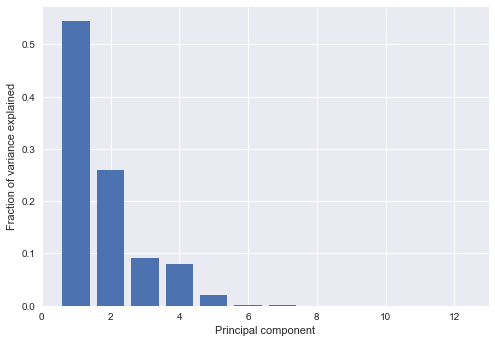

In [13]:
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.cm as cm

scaler = Normalizer()
pca = PCA()
steps = [('scaler', scaler), ('pca', pca)]
pipeline = Pipeline(steps)

col_X = [col for col in df.columns if col.startswith('smart')]
X = df[col_X].values
pipeline.fit(X)

# We now plot the ratio of explained variance captured by the different principal components.
plt.bar(range(1,len(col_X)+1), pca.explained_variance_ratio_)
plt.xlabel('Principal component')
plt.ylabel('Fraction of variance explained')
plt.savefig(folder_name + '/pca_explained_ratio.jpg')
plt.show()

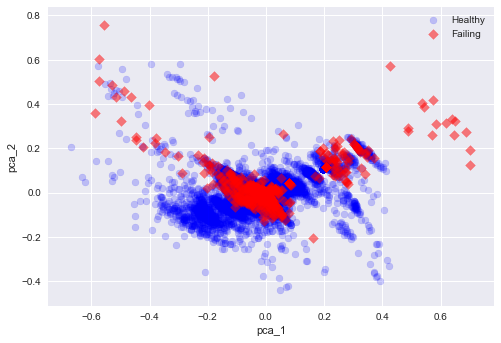

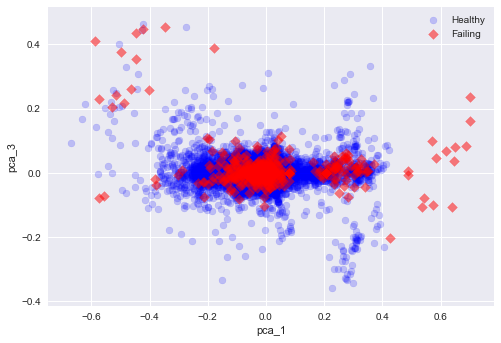

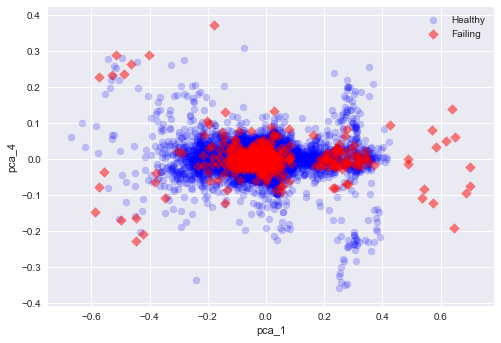

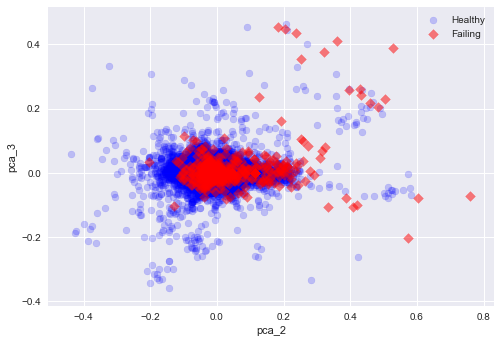

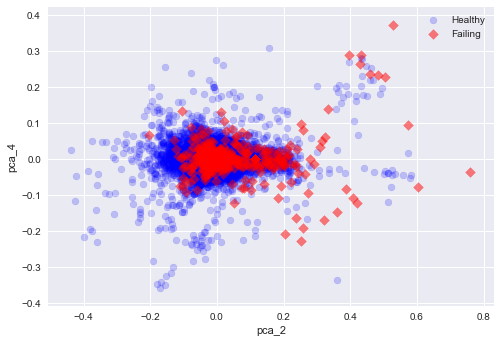

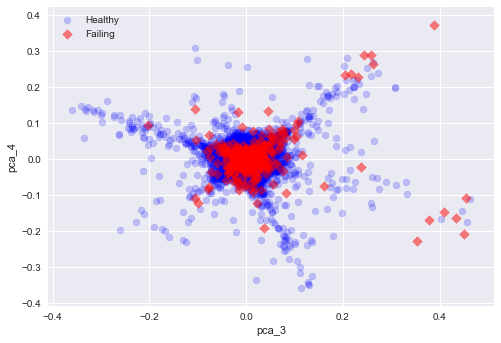

In [14]:
# Let us now observe whether the principal components can distinguish HDDs close to failure from those which are not.
n_comp = 4

pca2 = PCA(n_components = n_comp)
steps = [('scaler', scaler), ('pca', pca2)]
pipeline = Pipeline(steps)

pipeline.fit(X)

X_pca = pipeline.transform(X)

# Create a data frame containing the labels of the training observations and ...
y = df['label'].values
df_pca = pd.DataFrame({'cluster' : y})

# ... the value of the first n_comp PCA components
for i in range(1, n_comp + 1):
    col_name = 'pca_' + str(i)
    df_pca[col_name] = X_pca[:, i-1]

# Plot the scatterplots obtained by considering any 2 principal components among the first n_comp. Look at the patterns for halthy HDDs and close to failure HDDs.    
for ind_x in np.arange(1,n_comp) :
    for ind_y in np.arange (ind_x + 1, n_comp + 1) :
        plt.scatter(x = df_pca.loc[df_pca['cluster'] == 0, df_pca.columns[ind_x]], y = df_pca.loc[df_pca['cluster'] == 0, df_pca.columns[ind_y]], c = 'b', alpha = 0.2, label = 'Healthy')
        plt.scatter(x = df_pca.loc[df_pca['cluster'] == 1, df_pca.columns[ind_x]], y = df_pca.loc[df_pca['cluster'] == 1, df_pca.columns[ind_y]], marker = 'D', c = 'r', alpha = 0.5, label = 'Failing')
        plt.xlabel(df_pca.columns[ind_x])
        plt.ylabel(df_pca.columns[ind_y])
        plt.legend()
        plt.savefig(folder_name + '/pca_'+ str(ind_x) + str(ind_y) + '.jpg')
        plt.show()
        
del df_pca

#### Random Forest Classifier

We are now ready to train a classifier which would prescribe a predictive replacement policy and observe the performance it would have on the testing dataset. 

Observe that the training dataset is quite large, in particular for the model Hitachi HDS722020ALA330 we have almost 2 millions observations and 12 features. This makes classifiers such as KNeighbors and SVM quite inefficient due to the long training procedure. For this reason, we use a **Random Forest classifier**.

Before testing the classifier we need to tune the parameters of the random forest. To do so, we rely on cross validations using the masks defined above and the metric $M$. The parameters to tune are: 

- The number of features to randomly consider in every tree **max_features**. We consider trees with 2, 'sqrt' (3 or 4), and 0.5 (6) features. 
- The number of trees **n_estimators**. We consider 10, 100, and 1000 trees. 
- The threshold probability for positive class prediction **threshold_probs**. By default, the random forest classifier uses 0.5, we consider 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, and 0.95. 



In [15]:
# Split the training and testing dataset

# Select the column of the dataframe containing the features we will base our predictions on.
col_X = [col for col in df.columns if col.startswith('smart')]

# Use the masks defined above to determine X and y both for training and testing. 
X_train = df[col_X].loc[training_data_mask, :].values
X_test = df[col_X].loc[test_data_mask, :].values
y_train = df.loc[training_data_mask, 'label'].values
y_test = df.loc[test_data_mask, 'label'].values

# Build the dataframe with only the testing data
df_test = df.loc[test_data_mask, :]

In [16]:
# Evaluate the performance (total revenue) of the preventive replacement policy with respect to C across the testing dataset

# The preventive replacement revenue is given by (preventive_revenue_C0 - C*Failures_test).
# Compute the parameters not depending on C.
preventive_revenue_C0 = compute_revenue_preventive(dates, 0, df_test)[-1]
num_failures_test = np.sum(hdds_y_test)

revenue_prev = {}
for C in Cs :
    revenue_prev[C] = preventive_revenue_C0 - C*num_failures_test

**The cross validation phase requires some time to run. If interested only in the classifier with the best parameters skip the cells which state that in the comment.**  

For the model Hitachi HDS722020ALA330, to save time, we stored the best parameters obtained in the dictionary **best_params_by_C** where the key is the cost $C$ and the values are the associated best parameters in the format 

$$\text{C : ((max_features, n_estimators), threshold_probs)}.$$

best_params_by_C = {     
                    15: ((2, 10), 0.9),  
                    100: ((2, 10), 0.9),  
                    250: ((2, 10), 0.9),    
                    500: ((2, 10), 0.9),   
                    750: ((2, 10), 0.9),  
                   1000: ((2, 10), 0.9),  
                   1750: ((2, 10), 0.9),  
                   2500: ((2, 10), 0.9),  
                   5000: ((2, 10), 0.55),  
                   7500: ((2, 10), 0.55),  
                  10000: ((2, 10), 0.55) 
                   }


In [ ]:
######### TO BE SKIPPED IF INTERESTED ONLY IN THE BEST PARAMETERS #########

# Tune the parameters of the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import itertools

# List of parameters we aim to choose from. 
max_features_param = [2, 'sqrt', 0.5]
n_estimators_param = [10, 100, 1000]
threshold_probs = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95] 

# Create conf_mat, a dictionary in which the keys are a combination of parameters and the items are equal to [tn, fp, fn, tp] (one such list per cross-validating step).
params = list(itertools.product(max_features_param, n_estimators_param))
keys = list(itertools.product(params, threshold_probs))
conf_mat = {k: [] for k in keys}

# Iterate over the parameters needed in the initialization of the Random Forest classifier
for ind, param in enumerate(params) :
    
    rf = RandomForestClassifier(random_state=10, max_features = param[0], n_estimators = param[1])
    
    # Cross validate the results over the various folds
    for fold in range(NFolds) :
        # Split the training data in training and validating data (use masks created above)
        X_train_fold = X_train[ training_fold_data_mask[:, fold].astype(bool), :]
        y_train_fold = y_train[ training_fold_data_mask[:, fold].astype(bool)]
        X_val_fold = X_train[ validate_fold_data_mask[:, fold].astype(bool), :]
        y_val_fold = y_train[ validate_fold_data_mask[:, fold].astype(bool)]

        # Fit the training data and predict the probabilities for both training and validating data
        rf.fit(X_train_fold, y_train_fold)
        y_val_fold_proba = rf.predict_proba(X_val_fold)
        
        # Iterate over th threshold probabilities and save the list [tn, fp, fn, tp]
        for prob in threshold_probs :
            y_val_fold_pred = (y_val_fold_proba[:,1] > prob)
            tn, fp, fn, tp = confusion_matrix(y_val_fold, y_val_fold_pred).ravel()
            conf_mat[(param,prob)].append([tn, fp, fn, tp])


# Compute the best parameters for the random forest classifier. Based on the metric (gain_stop_failure*tp - loss_stop_healthy*fp)
# The results are already stored in the dictionary best_params_by_C initialized above. The code here provide a further comparison between the performance on the training and validating dataset.

best_params_by_C = {}

for C in Cs :
    
    gain_stop_failure = C - 1
    M_val = {}

    # Compute metrics for the validating datasets
    for k, v in conf_mat.items() :
        # Average performance across the cross validation steps
        tn, fp, fn, tp = (sum(i)/ len(v) for i in zip(*v))
        M_val[k] = compute_M([tn, fp, fn, tp], gain_stop_failure)
    
    # Sort keys of M_val by their value score
    sorted_params_val = sort_keys_by_val(M_val)
    
    # Store the best parameters in the dictionary best_params_by_C
    best_params_by_C[C] = sorted_params_val[0][0] 

In [17]:
best_params_by_C = {
15: ((2, 10), 0.9),
100: ((2, 10), 0.9),
250: ((2, 10), 0.9),
500: ((2, 10), 0.9),
750: ((2, 10), 0.9),
1000: ((2, 10), 0.9),
1750: ((2, 10), 0.9),
2500: ((2, 10), 0.9),
5000: ((2, 10), 0.55),
7500: ((2, 10), 0.55),
10000: ((2, 10), 0.55) }

#### Evaluation of predictive replacement (Classifier - Daily) policy 

We now compute the revenue achieved by using the predictive replacement (Classifier - Daily) on the testing dataset. 

**The following cell require the dictionary best_params_by_C**. Such dictionary can be obtained through the cross validation procedure above or by copying the pre-saved dictionary.

The following cell also display a dataframe with the actions prescribed by the predictive replacement policy. 

In [18]:
# Evaluate the performance (total revenue) of the predictive replacement policy (Classifier - Daily) 
# and of the preventive replacement policy with respect to C across the testing dataset

revenue_daily = {}

# Train the Random Forest classifier on all the training dataset (including the validation sets) and then predict the values for the testing set
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Iterate over C
for C in Cs :
    # Extract the best parameters obtained from the cross validation above.
    best_params = best_params_by_C[C][0]
    prob_thresh = best_params_by_C[C][1]

    # Fit the Random Forest Classifier
    rf = RandomForestClassifier(random_state=10, max_features = best_params[0], n_estimators = best_params[1])
    rf.fit(X_train, y_train)
    
    # Predict
    rf_y_train_proba = rf.predict_proba(X_train)
    rf_y_test_proba = rf.predict_proba(X_test)
   
    # A) Predict the labels of the testing data.
    y_test_pred = (rf_y_test_proba[:,1] > prob_thresh)
    
    
    # C) Compute the total revenue when we use also predictive replacement. 
    # We also print all the additional actions taken and the change in revenue they cause.
    df_test['predictions'] = y_test_pred
    pred_dict[('Classifier_daily', C)] = y_test_pred
    predictive_revenue_cum, df_actions = compute_revenue_predictive(dates, C, df_test)
    revenue_daily[C] = predictive_revenue_cum[-1]
    change_revenue =  revenue_daily[C] - revenue_prev[C]
    
    # For every C, we plot :
    print('\nC = {}:    Difference in total revenue = {}, change of {}% \n'.format(C, change_revenue, (change_revenue*100)/revenue_prev[C]))
    if len(df_actions) > 0 :
        display(df_actions)
    
del df_test


C = 15:    Difference in total revenue = 0, change of 0.0% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-15,JK1105B8GG42WX,fail,2015-01-15,0



C = 100:    Difference in total revenue = 0, change of 0.0% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-15,JK1105B8GG42WX,fail,2015-01-15,0



C = 250:    Difference in total revenue = 0, change of 0.0% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-15,JK1105B8GG42WX,fail,2015-01-15,0



C = 500:    Difference in total revenue = 0, change of 0.0% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-15,JK1105B8GG42WX,fail,2015-01-15,0



C = 750:    Difference in total revenue = 0, change of 0.0% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-15,JK1105B8GG42WX,fail,2015-01-15,0



C = 1000:    Difference in total revenue = 0, change of 0.0% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-15,JK1105B8GG42WX,fail,2015-01-15,0



C = 1750:    Difference in total revenue = 0, change of 0.0% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-15,JK1105B8GG42WX,fail,2015-01-15,0



C = 2500:    Difference in total revenue = 0, change of 0.0% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-15,JK1105B8GG42WX,fail,2015-01-15,0



C = 5000:    Difference in total revenue = 11268, change of 2.4318129826181916% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,4986
1,2015-01-01,JK11A5B8HZ9STX,fail,2015-05-29,4852
2,2015-02-05,JK1101B9KLLH4T,healthy,2016-08-19,-561
3,2015-02-20,JK1175YAHSNZKX,healthy,2015-12-23,-306
4,2015-03-08,JK11A8B9J49N3F,healthy,2016-08-05,-516
5,2015-04-12,JK11A8B9J8E2AF,healthy,2016-07-21,-466
6,2015-04-15,JK1101B9GBHE8F,healthy,2016-08-24,-497
7,2015-04-22,JK1175YAHU2WRX,healthy,2015-12-23,-245
8,2015-10-31,JK1101B9J2YV6F,healthy,2016-07-21,-264
9,2015-12-09,JK11A8B9J34AVF,healthy,2016-07-20,-224



C = 7500:    Difference in total revenue = 18768, change of 5.095043408857688% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,7486
1,2015-01-01,JK11A5B8HZ9STX,fail,2015-05-29,7352
2,2015-02-05,JK1101B9KLLH4T,healthy,2016-08-19,-561
3,2015-02-20,JK1175YAHSNZKX,healthy,2015-12-23,-306
4,2015-03-08,JK11A8B9J49N3F,healthy,2016-08-05,-516
5,2015-04-12,JK11A8B9J8E2AF,healthy,2016-07-21,-466
6,2015-04-15,JK1101B9GBHE8F,healthy,2016-08-24,-497
7,2015-04-22,JK1175YAHU2WRX,healthy,2015-12-23,-245
8,2015-10-31,JK1101B9J2YV6F,healthy,2016-07-21,-264
9,2015-12-09,JK11A8B9J34AVF,healthy,2016-07-20,-224



C = 10000:    Difference in total revenue = 26268, change of 9.609376714784275% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,9986
1,2015-01-01,JK11A5B8HZ9STX,fail,2015-05-29,9852
2,2015-02-05,JK1101B9KLLH4T,healthy,2016-08-19,-561
3,2015-02-20,JK1175YAHSNZKX,healthy,2015-12-23,-306
4,2015-03-08,JK11A8B9J49N3F,healthy,2016-08-05,-516
5,2015-04-12,JK11A8B9J8E2AF,healthy,2016-07-21,-466
6,2015-04-15,JK1101B9GBHE8F,healthy,2016-08-24,-497
7,2015-04-22,JK1175YAHU2WRX,healthy,2015-12-23,-245
8,2015-10-31,JK1101B9J2YV6F,healthy,2016-07-21,-264
9,2015-12-09,JK11A8B9J34AVF,healthy,2016-07-20,-224


## B.2. Classifier - Time Series

In this secon approach we giv more importance at the evolution of the smart metrics across multiple days. In approach B.1 (Classifier- Daily) we did that by considering relative differences, however to have a complete description of the SMART metric evolution, we would need to add too many features (one per SMART metric and relative difference in days considered). 

In the following analysis we extend this approach by looking at the SMART metrics across multiple days. 

- **Each observation will consist of the SMART metric evolution for the observed HDD in the last 15 days**. These observations are done every 5 days. We do not sample the time series' every day so as to avoid having extremely correlated observations (1/3 of the time series in two consecutive observations is different) and we also reduce the CPU memory needed to store a time series per day by a factor 5.

- We also need a way to compare time series. The default classifiers available work with floats, not with time series (vectors of float). To obviate this **we define a distance for time series and look at the distance of each time series with respect to a set of benchmark time series'**. The valiues of these distances are float and can be used as inputs for default classifiers. 

Note that we also explored the possibility to apply KNeighbor classifiers using this distance directly to the extracted time series'. However, the computational cost of this approach turned out to be prohibitive. 

#### Construction of the time series dataframe

The function below splits a time series in a list of sub-time series. Each sub-time series has a length of at most $15$ and is sampled by the original time series keeping the (at most) $15$ entries prior to an entry with index multiple of $5$. 

In practice, we look at the dataframe every $5$ days and store the observations of the prior $15$ ones.

In [19]:
def daily_to_ts(seq, size = 15, step = 5):
    """ Split up a seq in pieces of size 15 each terminating at a muliple of 5 observation"""
    #return [seq[i:i+size] for i in range(0, len(seq), int(size/2))]
    return [ seq[max(i - size, 0) : min(i, len(seq))] for i in range(step, len(seq)+1, step)]

# Apply the function daily_to_ts to the columns of interest of the original dataframe.

# The columns of interest are 'serial_number', 'date', 'failure', 'state', 'D_to_last', and the SMART metrics values. 
# Store the splitted time series in the dataframe df_ts.
df_ts = df[['serial_number', 'date', 'failure', 'state', 'D_to_last'] + smart_metrics]

# Create the dataframe df_grouped, the index are given by the serial_number and the 
# observations are list of sublists obtained by applying daily_to_ts to the full time series associated to every HDD. 
df_grouped = pd.DataFrame()
for sm in smart_metrics :
    df_grouped[sm] = df_ts.groupby('serial_number')[sm].apply(daily_to_ts)
df_grouped['D_to_last'] = df_ts.groupby('serial_number')['D_to_last'].apply(daily_to_ts)   
df_grouped['date'] = df_ts.groupby('serial_number')['date'].apply(daily_to_ts)   


Each observation in **df_grouped** consists of a list of sublists indexed by the serial number of the HDD observed. In the dataframe we aim to obtain **df_ts_ext**, the list of sublists has to be flattened: each observation will be given by one of the sublist. 

The dataframe will be created from the dictionary ts_data that we initialize starting from the dataframe df_grouped.

We will also label each observation with a 0 or a 1. It will be a 1 if the date of the observation (the last of the 15 days indexing the sublist) is at less than $15$ days from the failure of the associated HDD. 

In [20]:
# Define the threshold window to label oservations as close to failure
W = 15

# Initialize the dictionary we will use to create the dataframe df_ts_ext
ts_data = {}
ts_data['label'] = []                  # List of labels for the observations
ts_data['date'] = []                   # List of dates of the observations
ts_data['serial_number'] = []          # List of the HDDs observed
for sm in smart_metrics :
    ts_data[sm] = []                   # List of time series sublists observed

# Iterate over the HDDs, i.e., indices of df_grouped
for sn in df_grouped.index :
    # We will observe the HDD as many time as the length of the list stored in df_grouped.loc[sn, 'D_to_last']
    ts_data['serial_number'] = ts_data['serial_number'] + [sn]*len(df_grouped.loc[sn, 'D_to_last'])
    
    # Look at the date of the observation
    ts_data['date'] = ts_data['date'] + [np.max(sublist) for sublist in df_grouped.loc[sn, 'date']]
    
    # Determine whether each observation is within the threshold window : is_final
    is_final = [(np.max(sublist) > -W ) for sublist in df_grouped.loc[sn, 'D_to_last']]
    # Determine whether the HDD observed will fail on its last day or is healthy
    is_failing = (df_serialnumber.loc[sn,'state'] == 'fail')
    # Combine the booleans above to determine the labels of each observation
    ts_data['label'] = ts_data['label'] + [(is_failing & is_final[i]) for i in range(len(is_final))]
    
    # Flatten and pile the sublists of the SMART metrics observed at every observation day  
    for sm in smart_metrics :
        ts_data[sm] = ts_data[sm] + [sublist.values for sublist in df_grouped.loc[sn, sm]]
        
# Create the dataframe df_ts_ext from the dictionary ts_data
df_ts_ext = pd.DataFrame(data=ts_data)        

del df_grouped
del df_ts

#### A suitable distance metric for time series 

The observations in **df_ts_ext** consist of time series', we thus need to define a distance that can be used to judge whether two time series' are close or not. 

The standard distance used to compare vectors of floats id the Euclidean distance. However, we beleve that such distance is not suitable for comparing time series in our case. There are two reasons for this: 

1) In its basic form, it cannot compare time series of different length (component by component computation). 

2) The Euclidean metric does not capture the closeness of two shifted time series, by this we means that the distance between $(x_1,\ldots,x_{100})$ and $(x_2,\ldots,x_{101})$ could be extremely large although the trend showed in them is very similar, just shifted by one entry. 

In order to overcome these problems, we use the **Dynamic Time Warping** distance which allows to compare vectors of different lengths and also 'speed up/down' and thus 'shift' the time series. A thorough description of this distance is beyond the scope of this notebook, details can be found on [Wikipedia](https://en.wikipedia.org/wiki/Dynamic_time_warping) or in the reference within this [blog post](http://alexminnaar.com/time-series-classification-and-clustering-with-python.html). 

In the functions below, we define the dtw distance to fit our case. In particular, we have that:

- __dtw_distance(s1, s2)__ : compute the dtw distance of two time series (no need for equal length).

- __dtw_distance_vec(l1, l2)__ : compute the dtw distance of two lists of time series by calling dtw_distance(s1, s2) component by component.


In [21]:
def dtw_distance(s1, s2):
    '''Compute dtw distance of time series s1 and s2'''
    DTW={}
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0
    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min( DTW[(i-1, j)], DTW[(i, j-1)], DTW[(i-1, j-1)]) 
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

def dtw_distance_vec(l1, l2):
    '''Compute dtw distance of two lists of time series l1 and l2, the lists are assumed of the same length'''
    dist = 0
    for i in range(len(l1)):
        dist = dist + dtw_distance(l1[i], l2[i])    
    return dist

Note that in the [blog post](http://alexminnaar.com/time-series-classification-and-clustering-with-python.html) is discussed how to exploit dtw distance to favor an application of KNeighbors classifier. Such approach is not feasible with our dataset, whose dimensions are out of range for an efficient implementation of KNeighbors calssifier. 

To obviate this **we rely on a different approach which exploits the dtw distance of the observed time series with some predefined time series used as benchmarks**.

The benchmark time series we consider are proxies for specific behaviors of the time series: 

- [100] - Proxy for a constantly good behavior (100 is the typical value for a SMART metric)
- [1] - Proxy for a constantly bad behavior (1 is the minimal value for a SMART metric)
- [100, 1] - Proxy for a worsening behavior
- [1, 100] - Proxy for an improving behavior
- [100, 1, 100] - Proxy for a worsening and then improving behavior
- [1, 100, 1] - Proxy for an improving and then worsening behavior

We further point out that the computation of the dtw distance require $\mathcal{O}(N_1 N_2)$ time, where $N_1$ and $N_2$ are the lengths of the two time series. The benchmark time series defined above are short and can be assumed to remain constant as the window of observation ($15$ in this specific case) grows large. Thus the complexity grows linearly in the window chosen making the approach quite scalable.

We construct the new columns of the dataframe and display the head of the modified dataframe. 

In [22]:
# Define the list of benchmark time series
benchmark_ts = [[100] , [1], [100, 1], [1, 100], [100, 1, 100], [1, 100, 1]]

# Compute the distances of every time series of every SMART metric and store it in a new column (one for each benchmark time series and each SMART metric)
for ind, ben_ts in enumerate(benchmark_ts) : 
    for sm in smart_metrics :
        col_name = sm + '_dist_to_' + str(ind)
        df_ts_ext[col_name] = [dtw_distance(s, ben_ts) for s in df_ts_ext[sm]]

df_ts_ext.head()

,date,label,serial_number,smart_196_normalized,smart_1_normalized,smart_5_normalized,smart_1_normalized_dist_to_0,smart_5_normalized_dist_to_0,smart_196_normalized_dist_to_0,smart_1_normalized_dist_to_1,...,smart_196_normalized_dist_to_2,smart_1_normalized_dist_to_3,smart_5_normalized_dist_to_3,smart_196_normalized_dist_to_3,smart_1_normalized_dist_to_4,smart_5_normalized_dist_to_4,smart_196_normalized_dist_to_4,smart_1_normalized_dist_to_5,smart_5_normalized_dist_to_5,smart_196_normalized_dist_to_5
0,2015-01-05,False,JK1100B8G3B7AT,"[100.0, 100.0, 100.0, 100.0, 100.0]","[100.0, 100.0, 100.0, 100.0, 100.0]","[100.0, 100.0, 100.0, 100.0, 100.0]",0.0,0.0,0.0,221.370730,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,140.007143,140.007143,140.007143
1,2015-01-10,False,JK1100B8G3B7AT,"[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...",0.0,0.0,0.0,313.065488,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,140.007143,140.007143,140.007143
2,2015-01-15,False,JK1100B8G3B7AT,"[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...",0.0,0.0,0.0,383.425351,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,140.007143,140.007143,140.007143
3,2015-01-20,False,JK1100B8G3B7AT,"[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...",0.0,0.0,0.0,383.425351,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,140.007143,140.007143,140.007143
4,2015-01-25,False,JK1100B8G3B7AT,"[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...",0.0,0.0,0.0,383.425351,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,140.007143,140.007143,140.007143


#### Training, validating and testing dataset 

Before starting any learning procedure, we have to split the data in training and test data. We use the same splitting obtained in Section 4.A.1. 

We identify training and testing HDDs, and then further determine the same n_fold cross validation split for the training HDDs.

In [23]:
### NFolds, kf, hdds_X_train_list, and training_models  have already been defined in Section 4.A.1. 
## The masks defined below have the exact same meaning as above but are now filtering the observations in df_ts_ext instead of df

# Split the observations in training and testing 

training_data_ts_mask = [(x in training_models) for x in df_ts_ext['serial_number']]
test_data_ts_mask = [(not x) for x in training_data_ts_mask]

# Split the training observations in training and validating

df_ts_train_sn = df_ts_ext.loc[training_data_ts_mask, 'serial_number']

training_fold_data_ts_mask = np.zeros((np.sum(training_data_ts_mask), NFolds))
validate_fold_data_ts_mask = np.zeros((np.sum(training_data_ts_mask), NFolds))

for ind, x in enumerate(df_ts_train_sn) :
    ind_x = hdds_X_train_list.index(x)
    for ind_f, train_test_index in enumerate(kf):
        test_index = train_test_index[1]
        if (ind_x >= test_index[0]) & (ind_x <= test_index[-1]) :
            validate_fold_data_ts_mask[ind, ind_f] = 1
        else : 
            training_fold_data_ts_mask[ind, ind_f] = 1      



In [24]:
num_cols = len(smart_metrics) * len(benchmark_ts)

Xts_train = df_ts_ext.iloc[training_data_ts_mask, -num_cols :].values
Xts_test = df_ts_ext.iloc[test_data_ts_mask, -num_cols :].values
yts_train = df_ts_ext.loc[training_data_ts_mask, 'label'].values
yts_test = df_ts_ext.loc[test_data_ts_mask, 'label'].values


#### Random forest classifier

We are now ready to train a classifier which would prescribe a predictive replacement policy and observe the performance it would have on the testing dataset. For the same reasons as in the approach B.1, we consider a **Random Forest classifier**.

We first tune the parameters of the random forest through cross validation. **The cross validation phase requires some time to run. If interested only in the classifier with the best parameters skip the cells which state that in the comment.**  

For the model Hitachi HDS722020ALA330, to save time, we stored the best parameters obtained in the dictionary **best_params_ts_by_C** where the key is the cost $C$ and the values are the associated best parameters in the format 

$$\text{C : ((max_features, n_estimators), threshold_probs)}.$$

best_params_ts_by_C = {  
                      15: ((2, 10), 0.8),  
                      100: ((2, 10), 0.8),  
                      250: ((2, 10), 0.8),  
                      500: ((2, 10), 0.8),  
                      750: ((2, 10), 0.8),  
                     1000: ((2, 10), 0.8),  
                     1750: ((0.5, 10), 0.6),  
                     2500: ((0.5, 10), 0.6),  
                     5000: ((0.5, 10), 0.6),  
                     7500: ((0.5, 10), 0.6),  
                    10000: ((0.5, 10), 0.6)}




In [ ]:
######### TO BE SKIPPED IF INTERESTED ONLY IN THE BEST PARAMETERS #########

# Tune the parameters of the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import itertools

# List of parameters we aim to choose from. 
max_features_param = [2, 'sqrt', 0.5]
n_estimators_param = [10, 100, 1000]
threshold_probs = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95] 

# Create scores, a dictionary of lists with keys equal to a combination of parameters and item equal to a list of lists [tn, fp, fn, tp], one list per cross-validating step.
params = list(itertools.product(max_features_param, n_estimators_param))
keys = list(itertools.product(params, threshold_probs))
conf_ts_mat = {k: [] for k in keys}


for ind, param in enumerate(params) :
    
    rf = RandomForestClassifier(random_state=10, max_features = param[0], n_estimators = param[1])
    
    for fold in range(NFolds) :
        Xts_train_fold = Xts_train[ training_fold_data_ts_mask[:, fold].astype(bool), :]
        yts_train_fold = yts_train[ training_fold_data_ts_mask[:, fold].astype(bool)]
        Xts_val_fold = Xts_train[ validate_fold_data_ts_mask[:, fold].astype(bool), :]
        yts_val_fold = yts_train[ validate_fold_data_ts_mask[:, fold].astype(bool)]

        rf.fit(Xts_train_fold, yts_train_fold)
        yts_val_fold_proba = rf.predict_proba(Xts_val_fold)
        
        for prob in threshold_probs :
            yts_val_fold_pred = (yts_val_fold_proba[:,1] > prob)
            tn, fp, fn, tp = confusion_matrix(yts_val_fold, yts_val_fold_pred).ravel()
            conf_ts_mat[(param,prob)].append([tn, fp, fn, tp])

# Compute the best parameters for the random forest classifier. Based on the metric M
# The results are already stored in the dictionary best_params_by_C in the markdown above. 

best_params_ts_by_C = {}

for C in Cs :
    
    gain_stop_failure = C - 1
    M_ts_val = {}
    
    for k, v in conf_ts_mat.items() :
        tn, fp, fn, tp = (sum(i)/ len(v) for i in zip(*v))
        M_ts_val[k] = compute_M([tn, fp, fn, tp], gain_stop_failure)
    
    sorted_params_val = sort_keys_by_val(M_ts_val)
    best_params_ts_by_C[C] = sorted_params_val[0][0]       

In [25]:
best_params_ts_by_C = {
15: ((2, 10), 0.8),
100: ((2, 10), 0.8),
250: ((2, 10), 0.8),
500: ((2, 10), 0.8),
750: ((2, 10), 0.8),
1000: ((2, 10), 0.8),
1750: ((0.5, 10), 0.6),
2500: ((0.5, 10), 0.6),
5000: ((0.5, 10), 0.6),
7500: ((0.5, 10), 0.6),
10000: ((0.5, 10), 0.6)}

#### Evaluation of predictive replacement (Classifier - Time Series) policy 

We now compute the revenue achieved by using the predictive replacement (Classifier - Time Series) on the testing dataset. 

**The following cell require the dictionary best_params_ts_by_C**. Such dictionary can be obtained through the cross validation procedure above or by copying the pre-saved dictionary.

The following cell also display a dataframe with the actions prescribed by the predictive replacement policy. 

In [26]:
# Evaluate the performance (total revenue) of the predictive replacement policy (Classifier - Time Series) 
# and of the preventive replacement policy with respect to C across the testing dataset

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Consider the dataframe with only the testing data
df_ts_ext_test = df_ts_ext.loc[test_data_ts_mask, ['date', 'serial_number']]
df_test = df.loc[test_data_mask, ['serial_number', 'date', 'failure']]

revenue_ts = {}

for C in Cs :
    best_params = best_params_ts_by_C[C][0]
    prob_thresh = best_params_ts_by_C[C][1]

    rf = RandomForestClassifier(random_state=10, max_features = best_params[0], n_estimators = best_params[1])
    rf.fit(Xts_train, yts_train)
    rf_yts_test_proba = rf.predict_proba(Xts_test)

    yts_test_pred = (rf_yts_test_proba[:,1] > prob_thresh)
    
    
    # This is the only different lines of code with respect to approach A. Since we observe the metrics every 5 days, it implies that we do not prescribe to turn off a HDD every day we do not observe it. We do that by merging the prediction dataframe in the original dataframe.  
    df_ts_ext_test['predictions'] = yts_test_pred
    df_ts_ext_test_original = pd.merge(df_test, df_ts_ext_test, on = ['serial_number', 'date'], how = 'outer').fillna(False)
    pred_dict[('Classifier_ts', C)] = df_ts_ext_test_original['predictions'].values
    
    predictive_revenue_cum, df_actions = compute_revenue_predictive(dates, C, df_ts_ext_test_original)
    revenue_ts[C] = predictive_revenue_cum[-1]
    change_revenue =  revenue_ts[C] - revenue_prev[C]
    
    # For every C, we plot :
    print('\nC = {}:    Difference in total revenue = {}, change of {}% \n'.format(C, change_revenue, (change_revenue*100)/revenue_prev[C]))
    if len(df_actions) > 0 :
        display(df_actions)
    
del df_ts_ext_test
del df_ts_ext
del df_test


C = 15:    Difference in total revenue = 0, change of 0.0% 


C = 100:    Difference in total revenue = 0, change of 0.0% 


C = 250:    Difference in total revenue = 0, change of 0.0% 


C = 500:    Difference in total revenue = 0, change of 0.0% 


C = 750:    Difference in total revenue = 0, change of 0.0% 


C = 1000:    Difference in total revenue = 0, change of 0.0% 


C = 1750:    Difference in total revenue = 4288, change of 0.7306707925937791% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-10,JK1105B8GG42WX,fail,2015-01-15,1745
1,2015-01-15,JK11A5B8HZ9STX,fail,2015-05-29,1616
2,2015-01-20,JK1101B9JNPSGR,healthy,2016-10-21,-640
3,2015-06-14,JK1104B8JNLA8W,fail,2015-09-17,1655
4,2016-05-21,JK11A8YBKYDXMF,healthy,2016-08-19,-90



C = 2500:    Difference in total revenue = 6538, change of 1.1709333438403318% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-10,JK1105B8GG42WX,fail,2015-01-15,2495
1,2015-01-15,JK11A5B8HZ9STX,fail,2015-05-29,2366
2,2015-01-20,JK1101B9JNPSGR,healthy,2016-10-21,-640
3,2015-06-14,JK1104B8JNLA8W,fail,2015-09-17,2405
4,2016-05-21,JK11A8YBKYDXMF,healthy,2016-08-19,-90



C = 5000:    Difference in total revenue = 14038, change of 3.0296228833860646% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-10,JK1105B8GG42WX,fail,2015-01-15,4995
1,2015-01-15,JK11A5B8HZ9STX,fail,2015-05-29,4866
2,2015-01-20,JK1101B9JNPSGR,healthy,2016-10-21,-640
3,2015-06-14,JK1104B8JNLA8W,fail,2015-09-17,4905
4,2016-05-21,JK11A8YBKYDXMF,healthy,2016-08-19,-90



C = 7500:    Difference in total revenue = 21538, change of 5.847029248719995% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-10,JK1105B8GG42WX,fail,2015-01-15,7495
1,2015-01-15,JK11A5B8HZ9STX,fail,2015-05-29,7366
2,2015-01-20,JK1101B9JNPSGR,healthy,2016-10-21,-640
3,2015-06-14,JK1104B8JNLA8W,fail,2015-09-17,7405
4,2016-05-21,JK11A8YBKYDXMF,healthy,2016-08-19,-90



C = 10000:    Difference in total revenue = 29038, change of 10.622699902691709% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-10,JK1105B8GG42WX,fail,2015-01-15,9995
1,2015-01-15,JK11A5B8HZ9STX,fail,2015-05-29,9866
2,2015-01-20,JK1101B9JNPSGR,healthy,2016-10-21,-640
3,2015-06-14,JK1104B8JNLA8W,fail,2015-09-17,9905
4,2016-05-21,JK11A8YBKYDXMF,healthy,2016-08-19,-90


## B.3. Survival Regression

Here we quote from the [Lifelines](http://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html) package documentation:

> Traditionally, survival analysis was developed to measure lifespans of individuals. An actuary or health professional would ask questions like “how long does this population live for?”, and answer it using survival analysis. For example, the population may be a nation’s population (for actuaries), or a population stricken by a disease (in the medical professional’s case). Traditionally, sort of a morbid subject.

In our case, the HDDs represent the population, and the failure of an HDD is the event that correspond to the death. It is natural to use techniques from the survival analysis literature to tackle our problem. Specifically, we will use [Cox's proportional hazard model](http://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#cox-s-proportional-hazard-model) to understand the impact of the SMART metric values on the [survival function](http://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html#survival-function). 

#### Training and testing

We start by loading the dataframe, specifying only the columns that will be used in the following analysis.

We then split the original dataframe in training and testing according to the splitting obtained above. Note that the lifelines functions sometime requires the data in a dataframe format and sometimes in array. We thus keep both.

In [27]:
# Specify the numbers of the SMART metrics we will work with. 
useful_metrics = ['1', '5', '196']
smart_metrics = ['smart_' + x + '_normalized' for x in useful_metrics]
# Specify the columns we will load.
col_names = ['date','serial_number','failure', 'D_from_first', 'D_to_last', 'state'] + smart_metrics

# Load the main dataframe : df_s
df_s = pd.read_csv(folder_name + '/DataFrame.csv', parse_dates=['date'], usecols = col_names)

# Include a label column which is equal to 1 if the observation is relative to a HDD failing in the following 14 days.
df_s['label'] = (df_s['state'] == 'fail') & (df_s['D_to_last'] > -15).astype(int)


# Use the masks created above (intersection of original training mask and failing HDDs) to filter the HDDs used for training.
col_survival = ['D_from_first','failure'] + smart_metrics
df_X_train = df_s[col_survival].loc[training_data_mask, :]  
df_X_test = df_s[col_survival].loc[test_data_mask, :]
X_test = df_X_test[smart_metrics].values 

# Use the masks created above (original testing mask) to filter the HDDs used for testing.
df_y_test = df_s.loc[test_data_mask, 'label']
y_test = df_y_test.values
df_test_date = df_s.loc[test_data_mask, 'date']
df_test_sn = df_s.loc[test_data_mask, 'serial_number']




####  Cox's proportional hazard regression

Note that survival analysis is based on the durations at which the 'deaths' occur. In our case, most of the HDDs are already present on the first day (01-01-2015), hence, the exact age of an HDD cannot be known. Nevertheless, we observed in [Notebook 3](https://github.com/FabCec/planned_replacements/blob/master/3.%20Exploratory%20data%20analysis%20and%20inferential%20statistic.ipynb) we observed how the SMART metrics are not influenced by the age. We thus set to 0 the duration of an HDD already present in the dataframe on the starting date.

Thus, the durations are given exactly by the column [D_from_first] which contains the number of days passed from the first time the HDD was observed.

In [28]:
# Load the necessary functions from the package lifelines. In particular we will use the regressor CoxPHFitter.
from lifelines import CoxPHFitter
from sklearn.metrics import confusion_matrix
import itertools

# Fit the CoxPHFitter with the training data. 
# We need to specify the column of the duration [D_from_first] and the column of the event [failure]. 
# The fitting procedure is based on a numerical Newton-Raphson algorithm, the progress of the algorithm at the various iterating steps is displayed. 
cph = CoxPHFitter()
cph.fit(df_X_train, duration_col='D_from_first', event_col='failure', step_size = 0.1)



<lifelines.CoxPHFitter: fitted with 1954262 observations, 1954149 censored>

We can now predict the survival function for the testing data. 

Note that **cph.predict_survival_function(X_test) returns a DataFrame having as rows the 'Days to Failure' and as columns the 'Observations in the testing data'**, i.e., the entry $(i,j)$ correspond to the probability that the HDD relative to the $j$-th observation in the test dataset will survive for $i$ more days after being observed. 

Note that if we simply predict the value of X_test we end up with a dataframe of size roughly 1000x650000 yielding a memory error. To overcome this problem, we process X_test in batches and save only the survival function computed at days [1, 2, 5, 10, 20, 30] ending up with **df_pred** a more manageable 6x650000 dataframe.

In [29]:
# List of days for which we compute the survival function
days_to_failure = [1, 2, 5, 10, 20, 30]    

# Create the index batches
num_testing = len(X_test)
num_batches = 100
list_batches = np.array_split(range(num_testing), num_batches)

# For every batch, we predict the values of the survival function and save only the days in days_to_failure
df_pred = pd.DataFrame()
for i in range(num_batches) :
    x = X_test[list_batches[i],:]
    dfx = cph.predict_survival_function(x).iloc[days_to_failure, :]
    df_pred = pd.concat([df_pred, dfx], axis = 1)
    


We first tune the parameters of the survival regressor by checking the metric $M$ on the testing data set. We will implement in the future a cross-validation procedure similar to approaches B.1 and B.2, but we do not expect the results to change. 

An observation will be labeled with a 1 if the survival function evaluated at **days_to_failure** days is below probability **threshold_prob**. We thus have to tune both days_to_failure (taking values in [1, 2, 5, 10, 20, 30]) and threshold_prob (taking values in [0.5, 0.75, 0.9, 0.95, 0.98, 0.99, 0.995]).


In [31]:
# List of probabilities to choose from. 
threshold_probs = [0.5, 0.75, 0.9, 0.95, 0.98, 0.99, 0.995] 

keys = list(itertools.product(days_to_failure, threshold_probs))
conf_s_mat = {k: [] for k in keys}


for day in days_to_failure :
    prob_failure = df_pred.loc[day,:]
    for prob in threshold_probs :
        y_test_pred = ( prob_failure < prob)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
        conf_s_mat[(day,prob)] = [tn, fp, fn, tp]


best_params_s_by_C = {}

for C in Cs :
    
    gain_stop_failure = C - 1
    M_s_test = {}

    for k, v in conf_s_mat.items() :
        M_s_test[k] = compute_M(v, gain_stop_failure)
        
    sorted_params = sort_keys_by_val(M_s_test)
    
    best_params_s_by_C[C] = sorted_params[0][0]           
        


#### Evaluation of predictive replacement (Survival Regression) policy 

We now compute the revenue achieved by using the predictive replacement (Survival Regression) on the testing dataset. 

The following cell displays a dataframe with the actions prescribed by the predictive replacement policy.

In [32]:
# Evaluate the performance (total revenue) of the predictive replacement policy (Classifier - Time Series) 
# and of the preventive replacement policy with respect to C across the testing dataset

df_X_test['date'] = df_test_date.values
df_X_test['serial_number'] = df_test_sn.values

revenue_s = {}
    
for C in Cs : 
    
    day = best_params_s_by_C[C][0]
    prob = best_params_s_by_C[C][1]
    
    prob_failure = df_pred.iloc[day,:]
    y_s_test_pred = ( prob_failure < prob).values

    df_X_test['predictions'] = y_s_test_pred
    pred_dict[('Survival_regressor', C)] = y_s_test_pred
    
    predictive_revenue_cum, df_actions = compute_revenue_predictive(dates, C, df_X_test)
    revenue_s[C] = predictive_revenue_cum[-1]
    change_revenue =  revenue_s[C] - revenue_prev[C]    

    # For every C, we plot :
    print('\nC = {}:    Difference in total revenue = {}, change of {}% \n'.format(C, change_revenue, (change_revenue*100)/revenue_prev[C]))
    if len(df_actions) > 0 :
        display(df_actions)

del df_X_test


C = 15:    Difference in total revenue = -71, change of -0.01087642542448697% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,1
1,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
2,2015-06-22,JK1104B8JNLA8W,fail,2015-09-17,-72



C = 100:    Difference in total revenue = 99, change of 0.015241133201346147% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,86
1,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
2,2015-06-22,JK1104B8JNLA8W,fail,2015-09-17,13



C = 250:    Difference in total revenue = 399, change of 0.06197018597268342% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,236
1,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
2,2015-06-22,JK1104B8JNLA8W,fail,2015-09-17,163



C = 500:    Difference in total revenue = 899, change of 0.14171808347967552% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,486
1,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
2,2015-06-22,JK1104B8JNLA8W,fail,2015-09-17,413



C = 750:    Difference in total revenue = 1399, change of 0.2238908680052108% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,736
1,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
2,2015-06-22,JK1104B8JNLA8W,fail,2015-09-17,663



C = 1000:    Difference in total revenue = 1899, change of 0.30860084698663215% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,986
1,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
2,2015-06-22,JK1104B8JNLA8W,fail,2015-09-17,913



C = 1750:    Difference in total revenue = 3399, change of 0.5791861063494065% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,1736
1,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
2,2015-06-22,JK1104B8JNLA8W,fail,2015-09-17,1663



C = 2500:    Difference in total revenue = 4899, change of 0.8773940733364616% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,2486
1,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
2,2015-06-22,JK1104B8JNLA8W,fail,2015-09-17,2413



C = 5000:    Difference in total revenue = 9899, change of 2.136361085812698% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,4986
1,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
2,2015-06-22,JK1104B8JNLA8W,fail,2015-09-17,4913



C = 7500:    Difference in total revenue = 14899, change of 4.044706508342427% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,7486
1,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
2,2015-06-22,JK1104B8JNLA8W,fail,2015-09-17,7413



C = 10000:    Difference in total revenue = 19899, change of 7.279465023888088% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,9986
1,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
2,2015-06-22,JK1104B8JNLA8W,fail,2015-09-17,9913


# B.4. Ensemble Method

We developed three different policies to identify HDDs close to failure. These approaches use different features of the dataframe and thus identify different patterns in the structure of HDDs approaching failure. 

The predictive replacement policies derived are thus complementary and can be combined in order to obtain a sort of **ensemble policy**. The latter prescribe to turn off an HDD if at least one of the policy derived says to do so.


In [33]:
df_test = df.loc[test_data_mask, ['date', 'serial_number', 'failure']]

revenue_en = {}

for C in Cs :
    
    # Derive the ensemble predictor
    pred_dict[('Ensemble', C)] = [ ((pred_dict[('Classifier_daily', C)][i] | pred_dict[('Classifier_ts', C)][i]) | pred_dict[('Survival_regressor', C)][i]) for i in range(len(pred_dict[('Classifier_daily', C)]))]
    df_test['predictions'] = pred_dict[('Ensemble', C)]
    
    predictive_revenue_cum, df_actions = compute_revenue_predictive(dates, C, df_test)
    revenue_en[C] = predictive_revenue_cum[-1]
    change_revenue =  revenue_en[C] - revenue_prev[C]    

    # For every C, we plot :
    print('\nC = {}:    Difference in total revenue = {}, change of {}% \n'.format(C, change_revenue, (change_revenue*100)/revenue_prev[C]))
    if len(df_actions) > 0 :
        display(df_actions)
    
    


C = 15:    Difference in total revenue = -71, change of -0.01087642542448697% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,1
1,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
2,2015-06-22,JK1104B8JNLA8W,fail,2015-09-17,-72



C = 100:    Difference in total revenue = 99, change of 0.015241133201346147% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,86
1,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
2,2015-06-22,JK1104B8JNLA8W,fail,2015-09-17,13



C = 250:    Difference in total revenue = 399, change of 0.06197018597268342% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,236
1,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
2,2015-06-22,JK1104B8JNLA8W,fail,2015-09-17,163



C = 500:    Difference in total revenue = 899, change of 0.14171808347967552% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,486
1,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
2,2015-06-22,JK1104B8JNLA8W,fail,2015-09-17,413



C = 750:    Difference in total revenue = 1399, change of 0.2238908680052108% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,736
1,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
2,2015-06-22,JK1104B8JNLA8W,fail,2015-09-17,663



C = 1000:    Difference in total revenue = 1899, change of 0.30860084698663215% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,986
1,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
2,2015-06-22,JK1104B8JNLA8W,fail,2015-09-17,913



C = 1750:    Difference in total revenue = 4279, change of 0.7291372018443985% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,1736
1,2015-01-15,JK11A5B8HZ9STX,fail,2015-05-29,1616
2,2015-01-20,JK1101B9JNPSGR,healthy,2016-10-21,-640
3,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
4,2015-06-14,JK1104B8JNLA8W,fail,2015-09-17,1655
5,2016-05-21,JK11A8YBKYDXMF,healthy,2016-08-19,-90



C = 2500:    Difference in total revenue = 6529, change of 1.1693214747527572% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,2486
1,2015-01-15,JK11A5B8HZ9STX,fail,2015-05-29,2366
2,2015-01-20,JK1101B9JNPSGR,healthy,2016-10-21,-640
3,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
4,2015-06-14,JK1104B8JNLA8W,fail,2015-09-17,2405
5,2016-05-21,JK11A8YBKYDXMF,healthy,2016-08-19,-90



C = 5000:    Difference in total revenue = 15534, change of 3.3524833929704463% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,4986
1,2015-01-01,JK11A5B8HZ9STX,fail,2015-05-29,4852
2,2015-01-20,JK1101B9JNPSGR,healthy,2016-10-21,-640
3,2015-02-05,JK1101B9KLLH4T,healthy,2016-08-19,-561
4,2015-02-20,JK1175YAHSNZKX,healthy,2015-12-23,-306
5,2015-03-08,JK11A8B9J49N3F,healthy,2016-08-05,-516
6,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
7,2015-04-12,JK11A8B9J8E2AF,healthy,2016-07-21,-466
8,2015-04-15,JK1101B9GBHE8F,healthy,2016-08-24,-497
9,2015-04-22,JK1175YAHU2WRX,healthy,2015-12-23,-245



C = 7500:    Difference in total revenue = 25534, change of 6.931843478355296% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,7486
1,2015-01-01,JK11A5B8HZ9STX,fail,2015-05-29,7352
2,2015-01-20,JK1101B9JNPSGR,healthy,2016-10-21,-640
3,2015-02-05,JK1101B9KLLH4T,healthy,2016-08-19,-561
4,2015-02-20,JK1175YAHSNZKX,healthy,2015-12-23,-306
5,2015-03-08,JK11A8B9J49N3F,healthy,2016-08-05,-516
6,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
7,2015-04-12,JK11A8B9J8E2AF,healthy,2016-07-21,-466
8,2015-04-15,JK1101B9GBHE8F,healthy,2016-08-24,-497
9,2015-04-22,JK1175YAHU2WRX,healthy,2015-12-23,-245



C = 10000:    Difference in total revenue = 35534, change of 12.999070815560547% 



,date_action,HDD,state_HDD,last_presence,change_in_revenue
0,2015-01-01,JK1105B8GG42WX,fail,2015-01-15,9986
1,2015-01-01,JK11A5B8HZ9STX,fail,2015-05-29,9852
2,2015-01-20,JK1101B9JNPSGR,healthy,2016-10-21,-640
3,2015-02-05,JK1101B9KLLH4T,healthy,2016-08-19,-561
4,2015-02-20,JK1175YAHSNZKX,healthy,2015-12-23,-306
5,2015-03-08,JK11A8B9J49N3F,healthy,2016-08-05,-516
6,2015-04-07,JK1101B9KNMX1F,fail,2015-04-07,0
7,2015-04-12,JK11A8B9J8E2AF,healthy,2016-07-21,-466
8,2015-04-15,JK1101B9GBHE8F,healthy,2016-08-24,-497
9,2015-04-22,JK1175YAHU2WRX,healthy,2015-12-23,-245


# C. Comparison of the results

- As $C$ is low, both approaches B.1 and B.2 are cautious and inclined to not label as close to failure any HDD in order not to risk false positive (and the consequent loss of revenue).
- As $C$ grows large, both approaches B.1 and B.2 favor a more aggressive policy. It is not too bad if there are some false positive as long as some true positives are present as well.
  - The switch in policy happens for lower values of $C$ in case of approach B.2, i.e., for $C = 1750$, we may increase the revenue if we use that policy, not if we use the daily observation one.
  - The time series policy seems slightly more accurate (the revenue is higher), in fact there are less healthy HDDs that are classified as close to failure and thus wrongly turnd off ahead of time.

- The survival regressor behaves differently: it does not classify any non-failing HDD as close to failure. For this reason, even for low values of $C$ it prescribe the termination of 3 HDDs. This cause a slight loss for $C = 15$ but already from $C=100$ the sign of the revenue cahnge is positive. As $C$ grows large the gain in revenue is lower than by using the classifiers B.1 and B.2

- The ensemble classifier ouperforms all the other but in case $C = 15$. That is because it exploits the different patterns identified by the three methods and captures thus a larger number of failing HDDs.


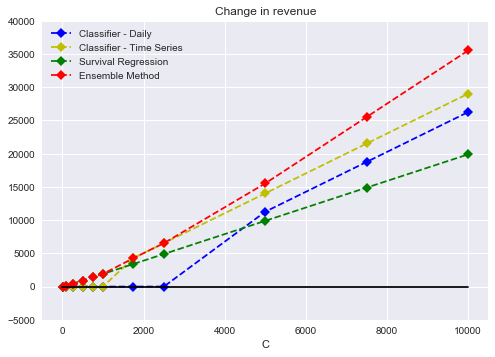

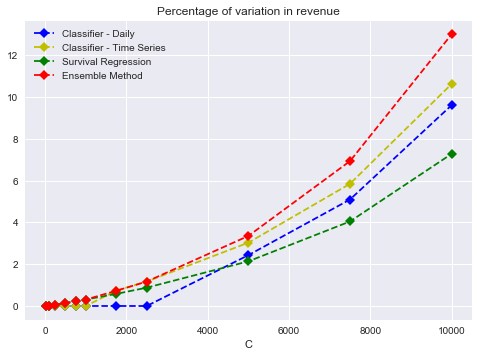

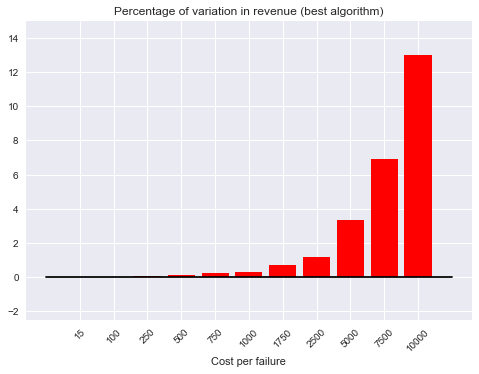

In [34]:
plt.plot(Cs, np.array(list(revenue_daily.values())) - np.array(list(revenue_prev.values())), 'b--', marker = 'D', label = 'Classifier - Daily')
plt.plot(Cs, np.array(list(revenue_ts.values())) - np.array(list(revenue_prev.values())), 'y--', marker = 'D', label = 'Classifier - Time Series')
plt.plot(Cs, np.array(list(revenue_s.values())) - np.array(list(revenue_prev.values())), 'g--', marker = 'D', label = 'Survival Regression')
plt.plot(Cs, np.array(list(revenue_en.values())) - np.array(list(revenue_prev.values())), 'r--', marker = 'D', label = 'Ensemble Method')
plt.plot([-1 , 10000], [0,0], color = 'k')
plt.xlabel('C')
plt.title('Change in revenue')
plt.ylim([-5000, 40000])
plt.legend()
plt.savefig(folder_name + '/Result_change.jpg')
plt.show()

#####

perc_d = ((list(revenue_daily.values()) - np.array(list(revenue_prev.values())))/np.array(list(revenue_prev.values())))*100
perc_ts = ((list(revenue_ts.values()) - np.array(list(revenue_prev.values())))/np.array(list(revenue_prev.values())))*100
perc_s = ((list(revenue_s.values()) - np.array(list(revenue_prev.values())))/np.array(list(revenue_prev.values())))*100
perc_en = ((list(revenue_en.values()) - np.array(list(revenue_prev.values())))/np.array(list(revenue_prev.values())))*100

plt.plot(Cs, perc_d, 'b--', marker = 'D', label = 'Classifier - Daily')
plt.plot(Cs, perc_ts, 'y--', marker = 'D', label = 'Classifier - Time Series')
plt.plot(Cs, perc_s, 'g--', marker = 'D', label = 'Survival Regression')
plt.plot(Cs, perc_en, 'r--', marker = 'D', label = 'Ensemble Method')
plt.xlabel('C')
plt.title('Percentage of variation in revenue')
plt.legend()
plt.savefig(folder_name + '/Result_perc.jpg')
plt.show()

####

plt.bar(range(len(Cs)), perc_en, color = 'r')
plt.plot([-1 , len(Cs)], [0,0], color = 'k')
plt.xlabel('Cost per failure')
plt.xticks(range(len(Cs)), Cs, rotation=45)
plt.title('Percentage of variation in revenue (best algorithm)')
plt.ylim([-2.5, 15])
plt.savefig(folder_name + '/Result.jpg')
plt.show()